In [1]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)


user_data = pd.read_sql('SELECT * FROM public.user_data', con=engine) # считываем таблицу
post_text_df = pd.read_sql('SELECT * FROM public.post_text_df', con=engine)
feed_data = pd.read_sql('SELECT * FROM public.feed_data limit 1000000', con=engine)

In [2]:
user_data.head()
user_data['user_id'].nunique()
# user_data.shape

163205

In [3]:
post_text_df.head()
post_text_df

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [4]:
feed_data.head(10)
feed_data.shape

(1000000, 5)

In [5]:
feed_data = feed_data[feed_data['action'] != 'like'] # оставляем только таргетную переменную
feed_data = feed_data.drop('action', axis = 1)
feed_data.isna().sum()

timestamp    0
user_id      0
post_id      0
target       0
dtype: int64

# Сперва поработаем с feed_data и поделим на train test

In [6]:
feed_data['timestamp'] = pd.to_datetime(feed_data['timestamp'])
feed_data = feed_data.sort_values(by = 'timestamp', ascending = True)
# feed_data['month'] = feed_data.timestamp.dt.month
feed_data['day_of_week'] = feed_data.timestamp.dt.day_of_week
# feed_data['day_of_month'] = feed_data.timestamp.dt.day
feed_data['hour'] = feed_data.timestamp.dt.hour
# feed_data = feed_data.drop(['day_of_month', 'month'], axis = 1)
feed_data

,timestamp,user_id,post_id,target,day_of_week,hour
371272,2021-10-01 06:05:25,64306,3494,0,4,6
97518,2021-10-01 06:06:45,166929,3954,0,4,6
799052,2021-10-01 06:06:45,25796,6047,0,4,6
210338,2021-10-01 06:06:45,12183,5965,0,4,6
139157,2021-10-01 06:07:11,77414,1401,1,4,6
...,...,...,...,...,...,...
365620,2021-12-29 23:38:27,19671,1267,0,2,23
591257,2021-12-29 23:38:34,105610,7096,0,2,23
365621,2021-12-29 23:41:03,19671,4601,0,2,23
591258,2021-12-29 23:41:20,105610,6946,0,2,23


***Делим выборку на трейн и тест***

In [7]:
split_date = feed_data['timestamp'].quantile(0.8)
train = feed_data[feed_data.timestamp < split_date]
test  = feed_data[feed_data.timestamp >= split_date]
# train['hour'].nunique()
train

,timestamp,user_id,post_id,target,day_of_week,hour
371272,2021-10-01 06:05:25,64306,3494,0,4,6
97518,2021-10-01 06:06:45,166929,3954,0,4,6
799052,2021-10-01 06:06:45,25796,6047,0,4,6
210338,2021-10-01 06:06:45,12183,5965,0,4,6
139157,2021-10-01 06:07:11,77414,1401,1,4,6
...,...,...,...,...,...,...
327298,2021-12-11 20:37:40,98611,230,0,5,20
55195,2021-12-11 20:37:49,98565,5915,0,5,20
877094,2021-12-11 20:37:49,19754,6220,0,5,20
419959,2021-12-11 20:37:49,33367,174,0,5,20


# Таблица user_data

In [8]:
user_data.nunique()

user_id      163205
gender            2
age              76
country          11
city           3915
exp_group         5
os                2
source            2
dtype: int64

In [9]:
os_ohe = pd.get_dummies(user_data["os"], prefix="os", dummy_na=False, dtype=int, drop_first = False)
source_ohe = pd.get_dummies(user_data["source"], prefix="source", dummy_na=False, dtype=int, drop_first = False)
exp_group_ohe= pd.get_dummies(user_data["exp_group"], prefix="exp", dummy_na=False, dtype=int, drop_first = False)
gender_ohe = pd.get_dummies(user_data["gender"], prefix="gender", dummy_na=False, dtype=int, drop_first = False)


In [10]:
train_user = pd.merge(train, user_data, on = 'user_id', how = 'left') # создаем временную таблицу для создания фичей
country_mean = (train_user.groupby('country')['target'].mean()) # усредненный показатель лайков по стране
global_mean = train_user['target'].mean() # среднее кол-во лайков по юзерам
city_mean = (train_user.groupby('city')['target'].mean()) # усредненный показатель по городам
# train_user['country_te'] = (train_user['country'].map(country_mean).fillna(global_mean))


In [11]:
likes_by_users = train_user.groupby('user_id').agg(likes = ('target', 'sum')).reset_index()
likes_by_users_2 = pd.merge(likes_by_users, user_data[['user_id','age']], on = 'user_id', how = 'left')

In [12]:
likes_by_age = likes_by_users_2.groupby('age').agg(age_like = ('likes', 'mean')).reset_index()
likes_by_age.head()

,age,age_like
0,14,43.000000
1,15,38.324675
2,16,39.623188
3,17,35.439252
4,18,36.308333


In [13]:
user_mean_like = train_user.groupby('user_id').agg(post_count = ('post_id', 'count')).reset_index()
# user_mean_like
likes_by_users_3 = pd.merge(likes_by_users_2, user_mean_like, on = 'user_id', how = 'left')

likes_by_users_3['perc_like'] = likes_by_users_3['likes'] / likes_by_users_3['post_count']
likes_by_users_3

,user_id,likes,age,post_count,perc_like
0,6866,20,20,311,0.064309
1,6867,70,28,371,0.188679
2,6868,16,21,292,0.054795
3,6869,52,21,518,0.100386
4,6870,108,27,460,0.234783
...,...,...,...,...,...
2124,167074,86,42,405,0.212346
2125,167075,44,23,267,0.164794
2126,167076,13,40,84,0.154762
2127,167077,34,19,370,0.091892


In [14]:
perc_likes_by_age = likes_by_users_3.groupby('age').agg(age_perc_like = ('perc_like', 'mean')).reset_index()


In [15]:
user_features = pd.concat(
    [
        user_data[["user_id","age"]],
        gender_ohe,
        os_ohe,
        source_ohe,
        exp_group_ohe
    ],
    axis=1
)
user_features['country_mte'] = (user_data['country'].map(country_mean).fillna(global_mean))
user_features['city_mte'] = (user_data['city'].map(city_mean).fillna(user_features['country_mte']))
user_features.isna().sum()

user_id           0
age               0
gender_0          0
gender_1          0
os_Android        0
os_iOS            0
source_ads        0
source_organic    0
exp_0             0
exp_1             0
exp_2             0
exp_3             0
exp_4             0
country_mte       0
city_mte          0
dtype: int64

In [16]:
user_features = pd.merge(user_features, likes_by_users_3[['user_id','likes', 'perc_like']], on = 'user_id', how = 'left')
user_features = pd.merge(user_features, likes_by_age[['age','age_like']], on = 'age', how = 'left')
user_features = pd.merge(user_features, perc_likes_by_age[['age','age_perc_like']], on = 'age', how = 'left')

user_features['age_like'] = user_features['age_like'].fillna(global_mean) # для новых возрастов заполним просто средним
user_features['likes'] = user_features['likes'].fillna(user_features['age_like']) #для неизвестных пользователей 
# заполним сначала средним по их возрасту если и возраст новый то общим средни кол-вом лайков

perc_like_mean = likes_by_users_3['perc_like'].mean()
user_features['age_perc_like'] = user_features['age_perc_like'].fillna(perc_like_mean) # для новых возрастов соотношение лайк/просмотр среднее
user_features['perc_like'] = user_features['perc_like'].fillna(user_features['age_perc_like']) # для новых людей сначала по возрасту потом общее среднее

user_features.isna().sum()

user_id           0
age               0
gender_0          0
gender_1          0
os_Android        0
os_iOS            0
source_ads        0
source_organic    0
exp_0             0
exp_1             0
exp_2             0
exp_3             0
exp_4             0
country_mte       0
city_mte          0
likes             0
perc_like         0
age_like          0
age_perc_like     0
dtype: int64

In [17]:
user_features

,user_id,age,gender_0,gender_1,os_Android,os_iOS,source_ads,source_organic,exp_0,exp_1,exp_2,exp_3,exp_4,country_mte,city_mte,likes,perc_like,age_like,age_perc_like
0,200,34,0,1,1,0,1,0,0,0,0,1,0,0.108256,0.108256,33.944444,0.105138,33.944444,0.105138
1,201,37,1,0,1,0,1,0,1,0,0,0,0,0.108256,0.135222,32.973684,0.099396,32.973684,0.099396
2,202,17,0,1,1,0,1,0,0,0,0,0,1,0.108256,0.127230,35.439252,0.110326,35.439252,0.110326
3,203,18,1,0,0,1,1,0,0,1,0,0,0,0.108256,0.146129,36.308333,0.119014,36.308333,0.119014
4,204,36,1,0,1,0,1,0,0,0,0,1,0,0.108256,0.130546,36.000000,0.105018,36.000000,0.105018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,36,1,0,1,0,0,1,0,0,0,0,1,0.108256,0.071815,36.000000,0.105018,36.000000,0.105018
163201,168549,18,1,0,1,0,0,1,0,0,1,0,0,0.108256,0.073093,36.308333,0.119014,36.308333,0.119014
163202,168550,41,0,1,1,0,0,1,0,0,0,0,1,0.108256,0.072350,37.391304,0.106219,37.391304,0.106219
163203,168551,38,1,0,0,1,0,1,0,0,0,1,0,0.108256,0.146129,30.225806,0.103983,30.225806,0.103983


In [18]:
TABLE_NAME = 'vadim_meshkov_pbr7487_user_features_lesson_22'

In [19]:
user_features.to_sql(
    TABLE_NAME,
    con=engine,
    if_exists="replace",
    index=False
)

205

In [20]:
check_df = pd.read_sql('SELECT * FROM vadim_meshkov_pbr7487_user_features_lesson_22', con = engine)

In [21]:
check_df

,user_id,age,gender_0,gender_1,os_Android,os_iOS,source_ads,source_organic,exp_0,exp_1,exp_2,exp_3,exp_4,country_mte,city_mte,likes,perc_like,age_like,age_perc_like
0,200,34,0,1,1,0,1,0,0,0,0,1,0,0.108256,0.108256,33.944444,0.105138,33.944444,0.105138
1,201,37,1,0,1,0,1,0,1,0,0,0,0,0.108256,0.135222,32.973684,0.099396,32.973684,0.099396
2,202,17,0,1,1,0,1,0,0,0,0,0,1,0.108256,0.127230,35.439252,0.110326,35.439252,0.110326
3,203,18,1,0,0,1,1,0,0,1,0,0,0,0.108256,0.146129,36.308333,0.119014,36.308333,0.119014
4,204,36,1,0,1,0,1,0,0,0,0,1,0,0.108256,0.130546,36.000000,0.105018,36.000000,0.105018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,36,1,0,1,0,0,1,0,0,0,0,1,0.108256,0.071815,36.000000,0.105018,36.000000,0.105018
163201,168549,18,1,0,1,0,0,1,0,0,1,0,0,0.108256,0.073093,36.308333,0.119014,36.308333,0.119014
163202,168550,41,0,1,1,0,0,1,0,0,0,0,1,0.108256,0.072350,37.391304,0.106219,37.391304,0.106219
163203,168551,38,1,0,0,1,0,1,0,0,0,1,0,0.108256,0.146129,30.225806,0.103983,30.225806,0.103983


# Таблица post_text_df

In [22]:
train.nunique()

timestamp      454860
user_id          2129
post_id          6831
target              2
day_of_week         7
hour               19
dtype: int64

In [23]:
train_post = post_text_df.loc[post_text_df['post_id'].isin(train['post_id'])].copy()

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
### Зафиттим наши данные в TfidfVectorizer

tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit(train_post['text'])
X_tfidf = tfidf.transform(post_text_df['text'])

In [25]:
tfidf_mean = X_tfidf.sum(axis=1) / (X_tfidf > 0).sum(axis=1)
post_text_df['tfidf_mean'] = np.asarray(tfidf_mean).ravel()
tfidf_max = X_tfidf.max(axis = 1)

post_text_df.loc[:, 'tfidf_max'] = tfidf_max.toarray().ravel()
post_text_df

,post_id,text,topic,tfidf_mean,tfidf_max
0,1,UK economy facing major risks\n\nThe UK manufa...,business,0.058606,0.434414
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,0.052896,0.290428
2,3,Asian quake hits European shares\n\nShares in ...,business,0.048951,0.278078
3,4,India power shares jump on debut\n\nShares in ...,business,0.074827,0.520815
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,0.077362,0.407433
...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,0.092687,0.230180
7019,7316,I give this movie 2 stars purely because of it...,movie,0.088948,0.331492
7020,7317,I cant believe this film was allowed to be mad...,movie,0.093582,0.507308
7021,7318,The version I saw of this film was the Blockbu...,movie,0.096505,0.264471


In [26]:
df_post = train.groupby('post_id').agg(post_like = ('target', 'sum'), post_count = ('post_id', 'count')).reset_index()
df_post = pd.merge(train_post, df_post, on = 'post_id', how = 'left')
df_post['post_perc_like'] = df_post['post_like'] / df_post['post_count']
df_post

,post_id,text,topic,post_like,post_count,post_perc_like
0,1,UK economy facing major risks\n\nThe UK manufa...,business,9,82,0.109756
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,6,83,0.072289
2,3,Asian quake hits European shares\n\nShares in ...,business,5,84,0.059524
3,4,India power shares jump on debut\n\nShares in ...,business,7,82,0.085366
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,17,100,0.170000
...,...,...,...,...,...,...
6826,7315,"OK, I would not normally watch a Farrelly brot...",movie,26,190,0.136842
6827,7316,I give this movie 2 stars purely because of it...,movie,6,66,0.090909
6828,7317,I cant believe this film was allowed to be mad...,movie,9,63,0.142857
6829,7318,The version I saw of this film was the Blockbu...,movie,8,71,0.112676


In [27]:
like_by_topic = df_post.groupby('topic').agg(sum_topic = ('post_like','sum'), count_topic = ('post_count', 'sum')).reset_index()
like_by_topic['topic_perc_like'] = like_by_topic['sum_topic'] / like_by_topic['count_topic']
like_by_topic

,topic,sum_topic,count_topic,topic_perc_like
0,business,5324,45440,0.117165
1,covid,19837,172800,0.114797
2,entertainment,4242,35975,0.117915
3,movie,30739,263893,0.116483
4,politics,7952,72671,0.109425
5,sport,11444,95038,0.120415
6,tech,2625,28918,0.090774


In [28]:
post_text_df_check = pd.merge(post_text_df, df_post[['post_id', 'post_like', 'post_perc_like']], on = 'post_id', how = 'left')
post_text_df_check = pd.merge(post_text_df_check, like_by_topic[['topic', 'topic_perc_like']], on = 'topic', how = 'left')
post_text_df_check['post_perc_like'] = post_text_df_check['post_perc_like'].fillna(0)
post_text_df_check['topic_perc_like'] = post_text_df_check['topic_perc_like'].fillna(0)
post_text_df_check['post_like'] = post_text_df_check['post_like'].fillna(0)
post_text_df_check.isna().sum()
post_text_df_check


,post_id,text,topic,tfidf_mean,tfidf_max,post_like,post_perc_like,topic_perc_like
0,1,UK economy facing major risks\n\nThe UK manufa...,business,0.058606,0.434414,9.0,0.109756,0.117165
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,0.052896,0.290428,6.0,0.072289,0.117165
2,3,Asian quake hits European shares\n\nShares in ...,business,0.048951,0.278078,5.0,0.059524,0.117165
3,4,India power shares jump on debut\n\nShares in ...,business,0.074827,0.520815,7.0,0.085366,0.117165
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,0.077362,0.407433,17.0,0.170000,0.117165
...,...,...,...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,0.092687,0.230180,26.0,0.136842,0.116483
7019,7316,I give this movie 2 stars purely because of it...,movie,0.088948,0.331492,6.0,0.090909,0.116483
7020,7317,I cant believe this film was allowed to be mad...,movie,0.093582,0.507308,9.0,0.142857,0.116483
7021,7318,The version I saw of this film was the Blockbu...,movie,0.096505,0.264471,8.0,0.112676,0.116483


In [29]:
topic_ohe = pd.get_dummies(post_text_df['topic'], dummy_na=False, dtype=int, drop_first = False)
post_features = pd.concat([
    post_text_df_check[["post_id", 'tfidf_mean', 'tfidf_max', 'post_like', 'post_perc_like', 'topic_perc_like']],
    topic_ohe], axis=1
)
post_features.head()

,post_id,tfidf_mean,tfidf_max,post_like,post_perc_like,topic_perc_like,business,covid,entertainment,movie,politics,sport,tech
0,1,0.058606,0.434414,9.0,0.109756,0.117165,1,0,0,0,0,0,0
1,2,0.052896,0.290428,6.0,0.072289,0.117165,1,0,0,0,0,0,0
2,3,0.048951,0.278078,5.0,0.059524,0.117165,1,0,0,0,0,0,0
3,4,0.074827,0.520815,7.0,0.085366,0.117165,1,0,0,0,0,0,0
4,5,0.077362,0.407433,17.0,0.170000,0.117165,1,0,0,0,0,0,0


In [30]:
TABLE_NAME = 'vadim_meshkov_pbr7487_post_features_lesson_22'

In [31]:
post_features.to_sql(
    TABLE_NAME,
    con=engine,
    if_exists="replace",
    index=False
)

23

In [32]:
check_df = pd.read_sql('SELECT * FROM vadim_meshkov_pbr7487_post_features_lesson_22', con = engine)

In [33]:
check_df

,post_id,tfidf_mean,tfidf_max,post_like,post_perc_like,topic_perc_like,business,covid,entertainment,movie,politics,sport,tech
0,1,0.058606,0.434414,9.0,0.109756,0.117165,1,0,0,0,0,0,0
1,2,0.052896,0.290428,6.0,0.072289,0.117165,1,0,0,0,0,0,0
2,3,0.048951,0.278078,5.0,0.059524,0.117165,1,0,0,0,0,0,0
3,4,0.074827,0.520815,7.0,0.085366,0.117165,1,0,0,0,0,0,0
4,5,0.077362,0.407433,17.0,0.170000,0.117165,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7315,0.092687,0.230180,26.0,0.136842,0.116483,0,0,0,1,0,0,0
7019,7316,0.088948,0.331492,6.0,0.090909,0.116483,0,0,0,1,0,0,0
7020,7317,0.093582,0.507308,9.0,0.142857,0.116483,0,0,0,1,0,0,0
7021,7318,0.096505,0.264471,8.0,0.112676,0.116483,0,0,0,1,0,0,0


# Анализ TF/IDF

In [427]:
# post_text_df_train = post_text_df.loc[post_text_df['post_id'].isin(train['post_id'])].copy()
# post_text_df_test =  post_text_df.loc[post_text_df['post_id'].isin(test['post_id'])].copy()


In [428]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# import numpy as np
# ### Зафиттим наши данные в TfidfVectorizer

# tfidf = TfidfVectorizer()

# X_train_tfidf = tfidf.fit_transform(post_text_df_train['text'])
# X_test_tfidf = tfidf.transform(post_text_df_test['text'])


In [636]:
# tfidf_mean = X_train_tfidf.sum(axis=1) / (X_train_tfidf > 0).sum(axis=1)
# post_text_df_train['tfidf_mean'] = np.asarray(tfidf_mean).ravel()
# tfidf_max = X_train_tfidf.max(axis = 1)

# post_text_df_train.loc[:, 'tfidf_max'] = tfidf_max.toarray().ravel()
# post_text_df_train.nunique()

post_id       6831
text          6747
topic            7
tfidf_mean    6728
tfidf_max     6724
dtype: int64

In [430]:
# train = pd.merge(train, post_text_df_train[['post_id','tfidf_mean', 'tfidf_max']], on = 'post_id', how = 'left')
# train.head()

,timestamp,user_id,post_id,target,gender,age,country,city,exp_group,os,source,text,topic,month,day_of_week,day_of_month,time,tfidf_mean,tfidf_max
0,2021-10-01 06:07:20,74454,5566,1,0,38,Russia,Dalnegorsk,4,iOS,ads,"Disgused as an Asian Horror, A Tale Of Two Sis...",movie,10,4,1,6,0.054090,0.289128
1,2021-10-01 06:07:20,81304,4884,1,0,44,Russia,Nizhniy Novgorod,1,Android,ads,The Mother tells of a recently widowed mid-60s...,movie,10,4,1,6,0.096028,0.285553
2,2021-10-01 06:07:30,47811,1394,0,0,21,Russia,Moscow,3,Android,ads,Italy 17-28 Ireland\n\nTwo moments of magic fr...,sport,10,4,1,6,0.047936,0.299891
3,2021-10-01 06:08:36,47811,1175,0,0,21,Russia,Moscow,3,Android,ads,Kilroy unveils immigration policy\n\nEx-chatsh...,politics,10,4,1,6,0.078420,0.385792
4,2021-10-01 06:08:40,9484,752,0,0,16,Kazakhstan,Nur-Sultan,0,Android,ads,Police praise courageous Ozzy\n\nRock star Ozz...,entertainment,10,4,1,6,0.044412,0.321839


In [432]:
# # делаем то же самое для данных в тест
# tfidf_mean = X_test_tfidf.sum(axis=1) / (X_test_tfidf > 0).sum(axis=1)
# post_text_df_test['tfidf_mean'] = np.asarray(tfidf_mean).ravel()
# tfidf_max = X_test_tfidf.max(axis = 1)

# post_text_df_test.loc[:, 'tfidf_max'] = tfidf_max.toarray().ravel()
# post_text_df_test.head(20)

,post_id,text,topic,tfidf_mean,tfidf_max
0,1,UK economy facing major risks\n\nThe UK manufa...,business,0.058606,0.434414
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,0.052896,0.290428
2,3,Asian quake hits European shares\n\nShares in ...,business,0.048951,0.278078
3,4,India power shares jump on debut\n\nShares in ...,business,0.074827,0.520815
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,0.077362,0.407433
5,6,Insurance bosses plead guilty\n\nAnother three...,business,0.079161,0.403255
6,14,Saudi investor picks up the Savoy\n\nLondons f...,business,0.079845,0.505943
8,7,Turkey-Iran mobile deal at risk\n\nTurkeys inv...,business,0.065866,0.339241
9,8,"Parmalat to return to stockmarket\n\nParmalat,...",business,0.060270,0.486013
10,9,WorldCom director admits lying\n\nThe former c...,business,0.046165,0.510503


In [433]:
# test = pd.merge(test, post_text_df_test[['post_id','tfidf_mean', 'tfidf_max']], on = 'post_id', how = 'left')
# test.head()

,timestamp,user_id,post_id,target,gender,age,country,city,exp_group,os,source,text,topic,month,day_of_week,day_of_month,time,tfidf_mean,tfidf_max
0,2021-12-21 07:06:04,101913,970,0,0,20,Ukraine,Dovzhansk,0,Android,ads,Boothroyd calls for Lords speaker\n\nBetty Boo...,politics,12,1,21,7,0.062373,0.433347
1,2021-12-21 07:06:04,9465,1604,0,0,25,Russia,Berezniki,1,Android,ads,Prutton poised for lengthy FA ban\n\nSouthampt...,sport,12,1,21,7,0.056496,0.467939
2,2021-12-21 07:06:04,16273,1440,0,1,29,Russia,Moscow,0,iOS,ads,Poll explains free-kick decision\n\nReferee Gr...,sport,12,1,21,7,0.057840,0.344631
3,2021-12-21 07:06:17,101862,2241,0,1,29,Russia,Moscow,3,iOS,ads,Poles play with GameBoy blip-pop\n\nA group of...,tech,12,1,21,7,0.044052,0.433681
4,2021-12-21 07:06:17,16223,1080,0,0,21,Russia,Kopeysk,3,iOS,ads,Abortion not a poll issue - Blair\n\nTony Blai...,politics,12,1,21,7,0.044019,0.481237


# Анализ временных признаков

In [316]:
# likes_by_month = train.groupby('month')['target'].sum().reset_index()
# likes_by_month

,month,target
0,10,28386
1,11,37895
2,12,27915


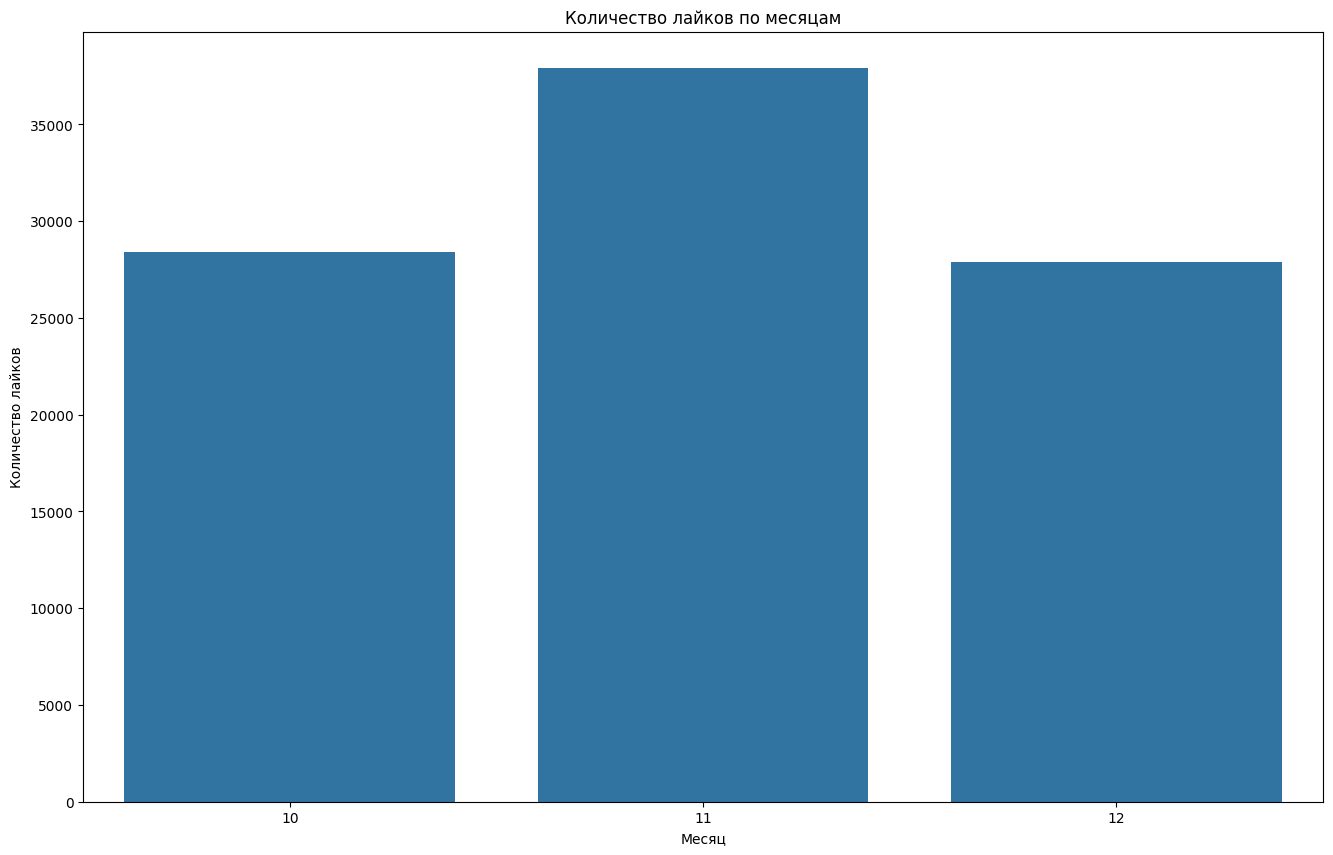

In [317]:

### Например, распределения таргета по месяцам

# import matplotlib.pyplot as plt
# import seaborn as sns


# plt.figure(figsize=(16, 10))
# sns.barplot(
#     data=likes_by_month,
#     x='month',
#     y='target'
# )
# plt.title('Количество лайков по месяцам')
# plt.ylabel('Количество лайков')
# plt.xlabel('Месяц')
# plt.show()

In [318]:
# likes_by_week = df.groupby('day_of_week')['target'].sum().reset_index()
# likes_by_week

,day_of_week,target
0,0,14974
1,1,15348
2,2,15627
3,3,14331
4,4,15423
5,5,15389
6,6,15448


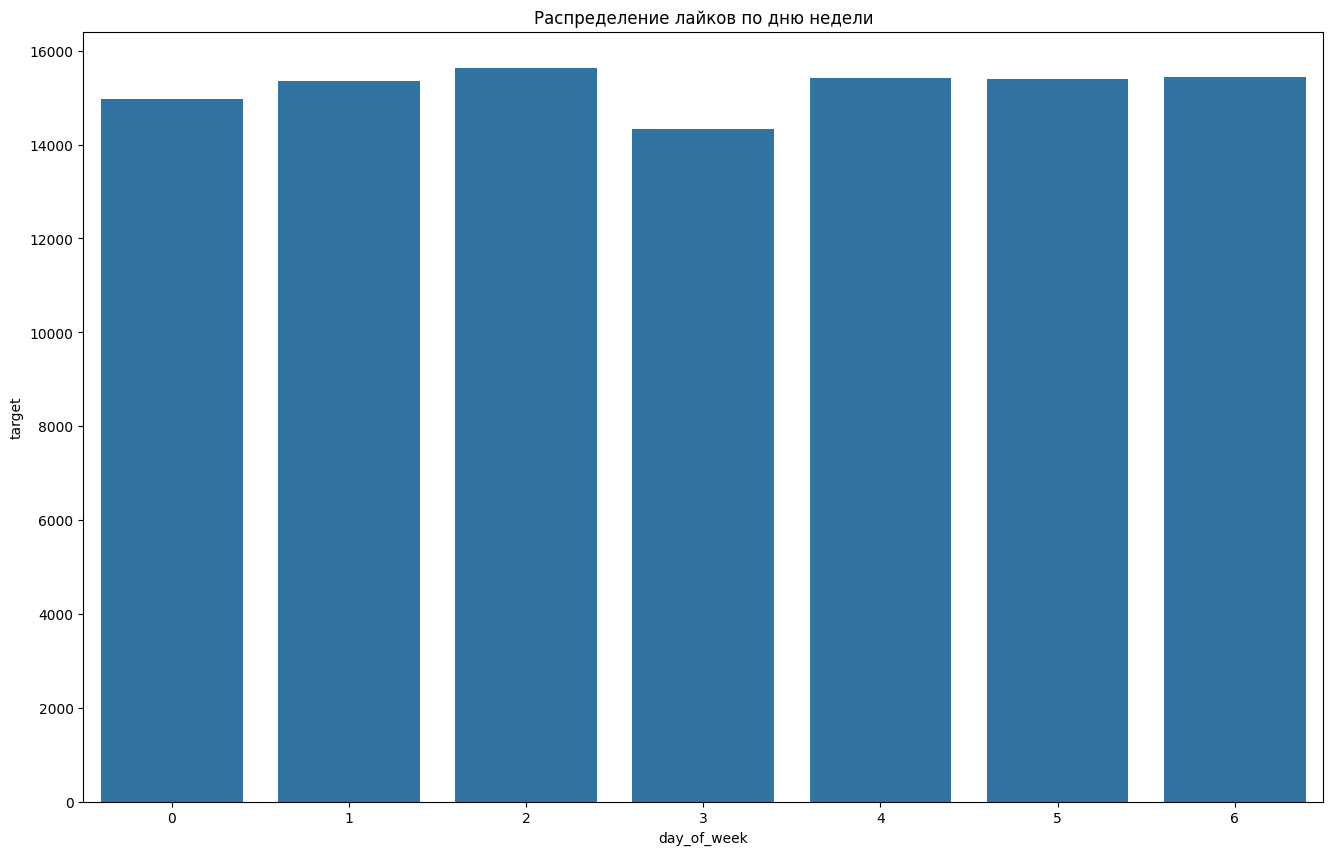

In [319]:
# plt.figure(figsize = (16, 10))
# sns.barplot(data = likes_by_week,
#             y = 'target',
#             x = 'day_of_week')
# plt.title('Распределение лайков по дню недели')
# plt.show()

In [320]:
# likes_by_day = df.groupby('day_of_month')['target'].sum().reset_index()
# likes_by_day.head()

,day_of_month,target
0,1,3817
1,2,3847
2,3,3702
3,4,3600
4,5,3445


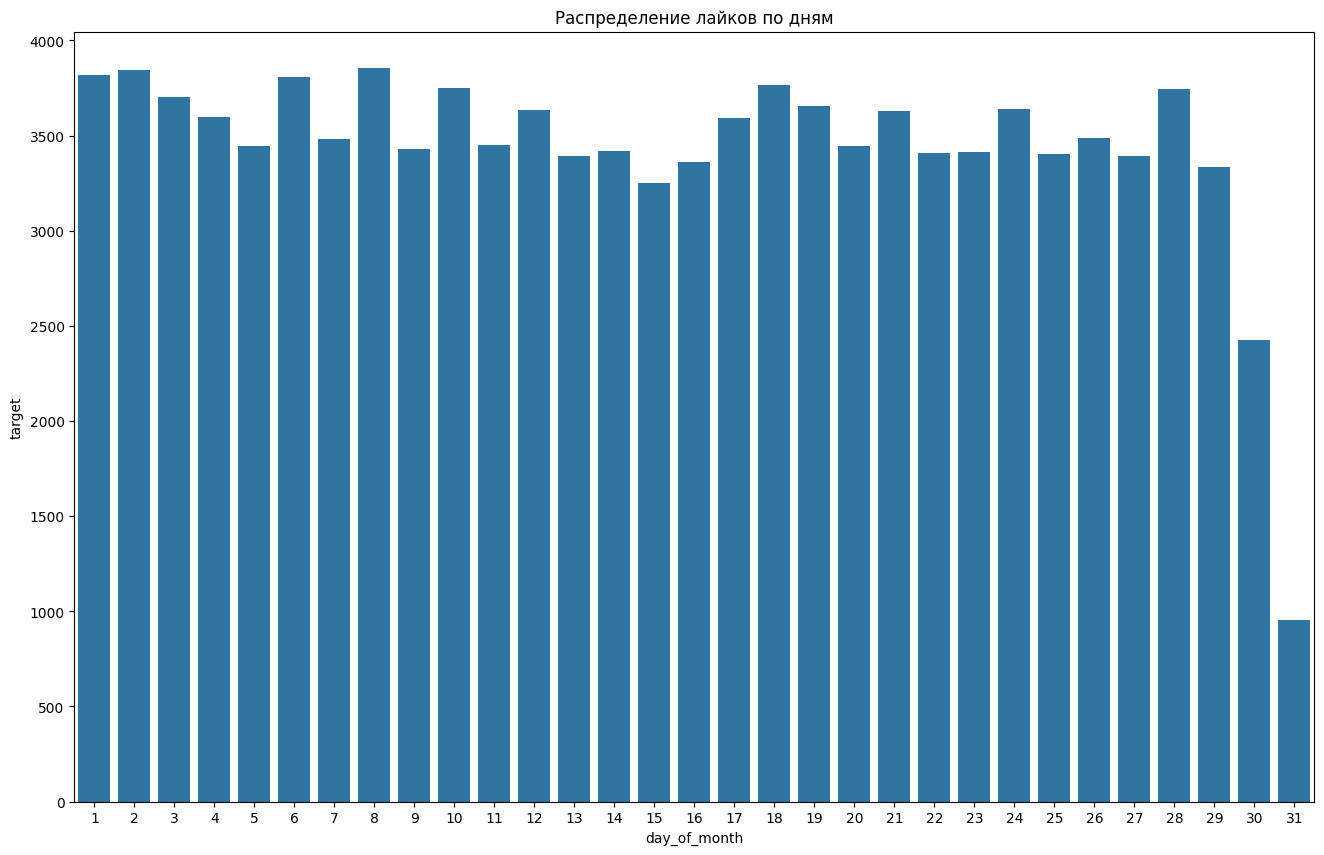

In [321]:
# plt.figure(figsize = (16, 10))
# sns.barplot(data = likes_by_day,
#             y = 'target',
#             x = 'day_of_month')
# plt.title('Распределение лайков по дням')
# plt.show()

In [322]:
# likes_by_hour = df.groupby('time')['target'].sum().reset_index()
# likes_by_hour.head()

,time,target
0,0,2
1,6,4325
2,7,6402
3,8,6234
4,9,5813


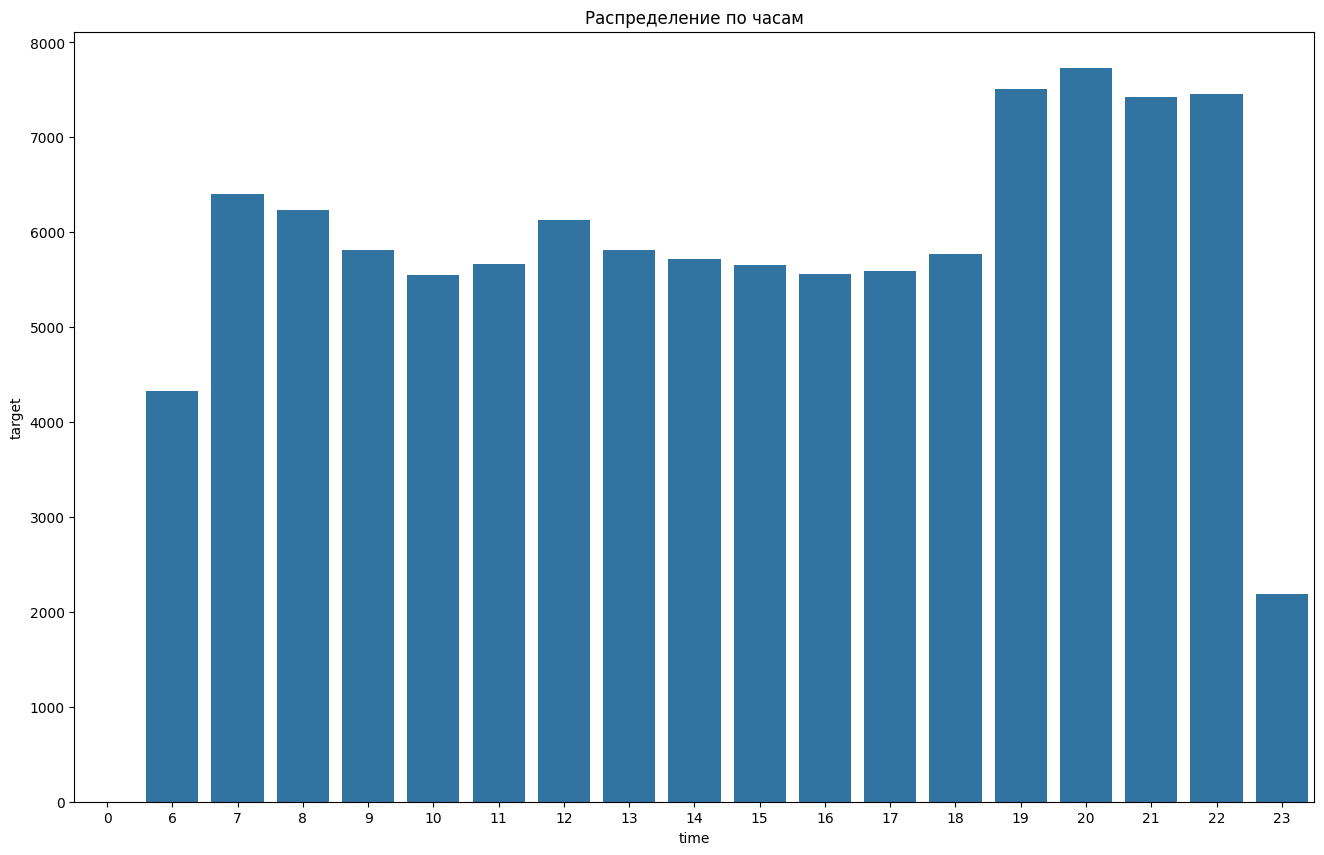

In [323]:
# plt.figure(figsize = (16, 10))
# sns.barplot(data = likes_by_hour,
#             y = 'target',
#             x = 'time')
# plt.title('Распределение по часам')
# plt.show()

# Анализ параметров с юзерами

In [434]:
# likes_by_age = train.groupby('age')['target'].sum().reset_index()
# likes_by_age.head()

,age,target
0,14,1260
1,15,3171
2,16,4718
3,17,4745
4,18,5447


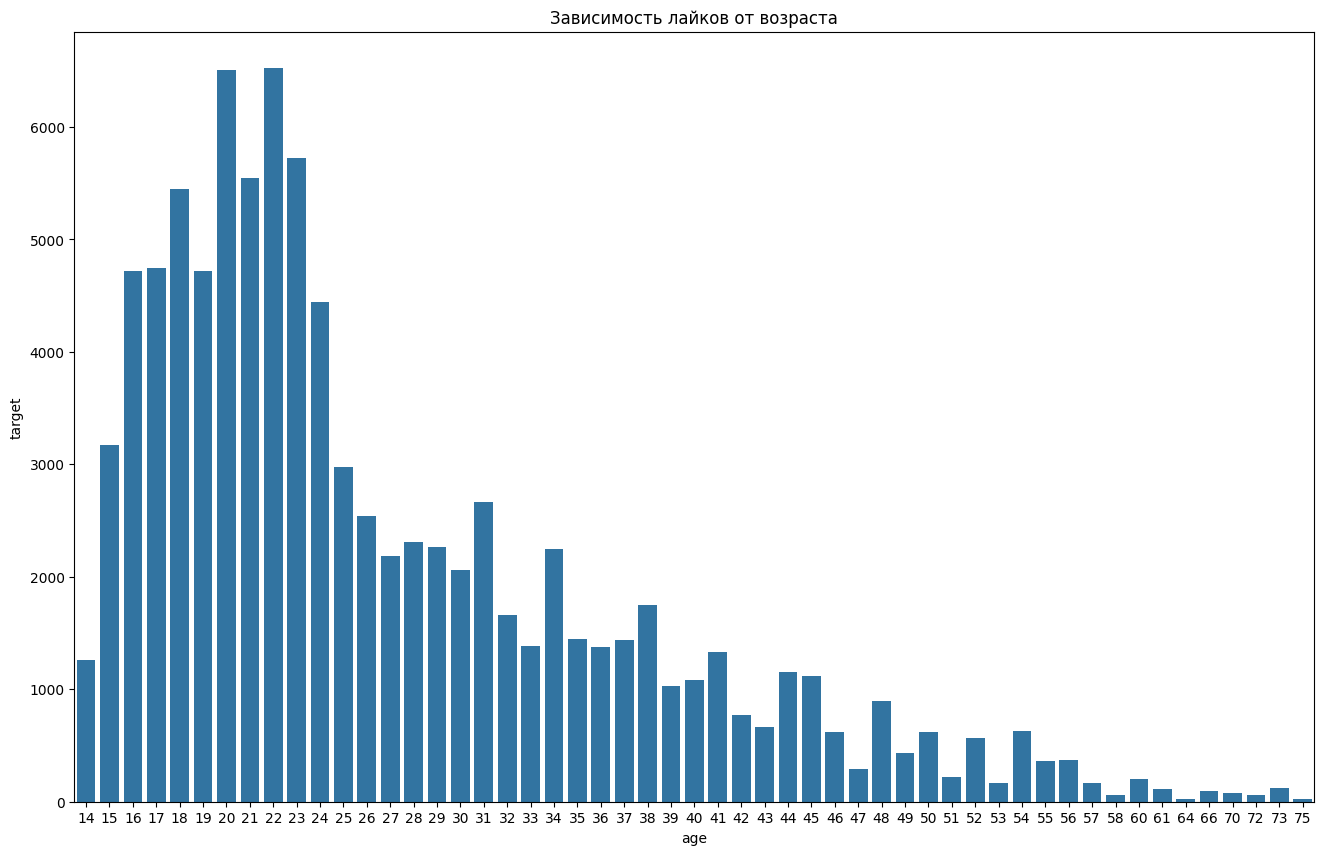

In [435]:
# plt.figure(figsize = (16, 10))
# sns.barplot(data = likes_by_age,
#             y = 'target',
#             x = 'age')
# plt.title('Зависимость лайков от возраста')
# plt.show()

In [436]:
# users_by_age = train.groupby('age')['user_id'].sum().reset_index()
# users_by_age.head()

,age,user_id
0,14,890726316
1,15,2140588960
2,16,2803112278
3,17,3448870800
4,18,4082569682


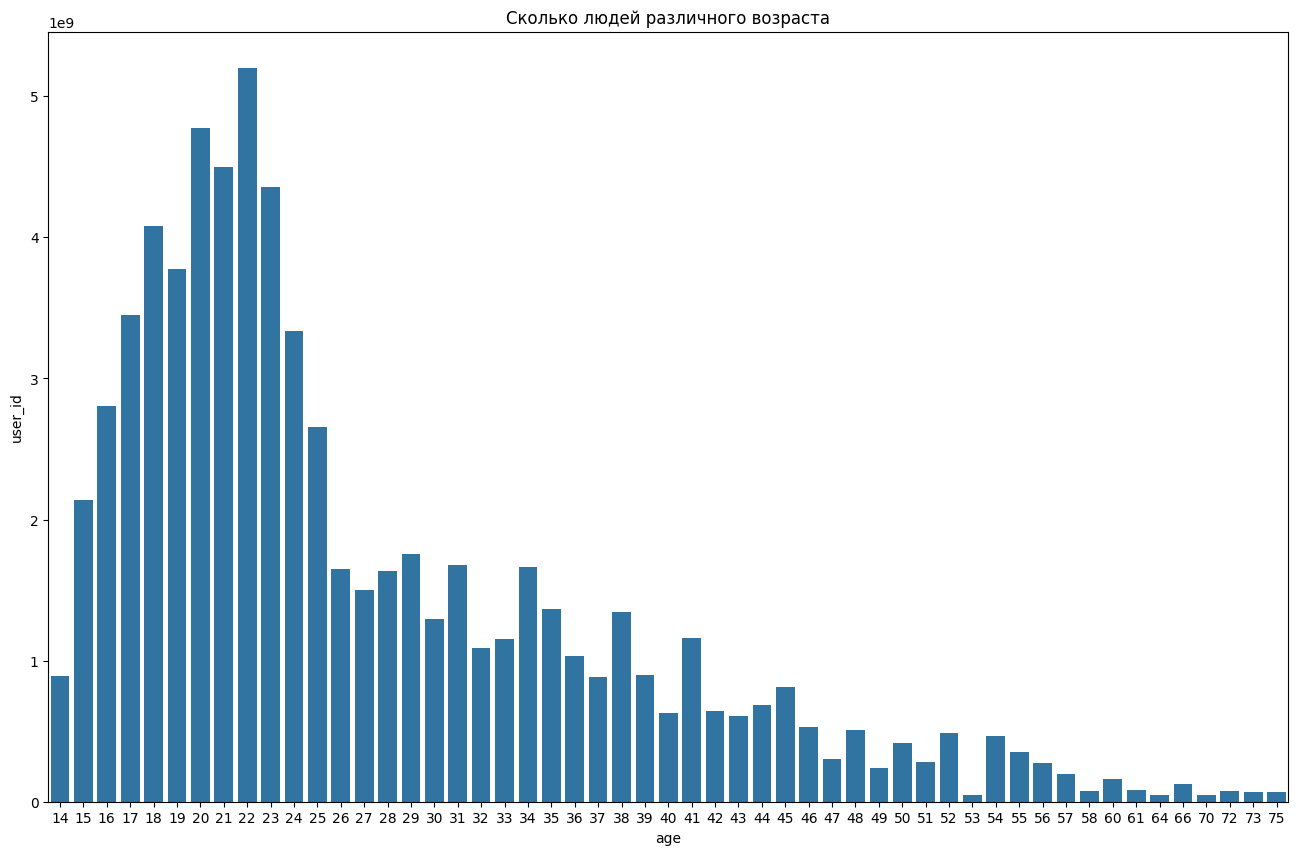

In [437]:
# plt.figure(figsize = (16, 10))
# sns.barplot(data = users_by_age,
#             y = 'user_id',
#             x = 'age')
# plt.title('Сколько людей различного возраста')
# plt.show()

In [438]:
# likes_by_users = train.groupby('user_id').agg(likes = ('target', 'sum')).reset_index()
# likes_by_users.head()
# # ///
# # likes_by_users.sort_values(by = 'likes')
# user_data_train = user_data.loc[user_data['user_id'].isin(train['user_id'])].copy()
# df_user_1 = pd.merge(user_data_train, likes_by_users, on = 'user_id', how = 'left')

# # df_user_1['likes'] = df_user_1['likes'].fillna(0)
# df_user_1.isna().sum()
# df_user_1

,user_id,gender,age,country,city,exp_group,os,source,likes
0,9450,1,24,Russia,Kaliningrad,3,iOS,ads,35
1,9451,1,37,Russia,Kemerovo,2,Android,ads,16
2,9452,0,16,Russia,Yekaterinburg,1,Android,ads,23
3,9453,0,17,Russia,Saint Petersburg,2,iOS,ads,79
4,9454,0,26,Russia,Staraya Mayna,0,Android,ads,33
...,...,...,...,...,...,...,...,...,...
2108,164806,0,18,Russia,Azov,1,Android,organic,6
2109,164807,1,20,Russia,Kazan,3,Android,organic,12
2110,164808,0,30,Russia,Moscow,3,iOS,organic,57
2111,164809,1,47,Russia,Murom,1,Android,organic,69


In [439]:
# likes_by_age = df_user_1.groupby('age').agg(age_like = ('likes', 'mean')).reset_index()
# likes_by_age.head()
# df_user_2 = pd.merge(df_user_1, likes_by_age, on = 'age', how = 'left')
# df_user_2.head()

,user_id,gender,age,country,city,exp_group,os,source,likes,age_like
0,9450,1,24,Russia,Kaliningrad,3,iOS,ads,35,47.244681
1,9451,1,37,Russia,Kemerovo,2,Android,ads,16,47.800000
2,9452,0,16,Russia,Yekaterinburg,1,Android,ads,23,45.365385
3,9453,0,17,Russia,Saint Petersburg,2,iOS,ads,79,43.136364
4,9454,0,26,Russia,Staraya Mayna,0,Android,ads,33,43.000000


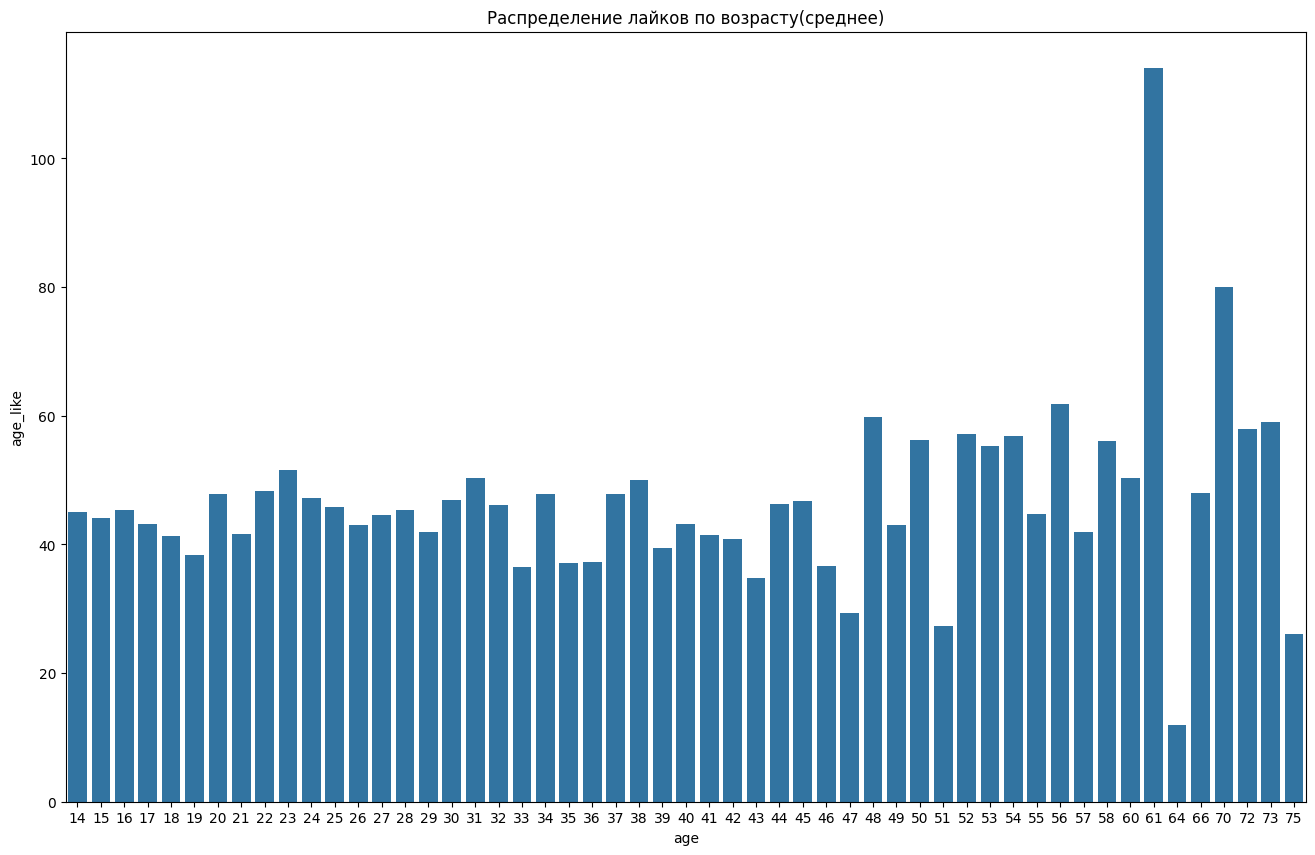

In [440]:
# plt.figure(figsize = (16, 10))
# sns.barplot(data = df_user_2,
#             x = 'age',
#             y = 'age_like')
# plt.title('Распределение лайков по возрасту(среднее)')
# plt.show()

In [584]:
# user_mean_like = train.groupby('user_id').agg(post_count = ('post_id', 'count')).reset_index()
# # user_mean_like
# df_user_3 = pd.merge(df_user_2, user_mean_like, on = 'user_id', how = 'left')

# df_user_3['perc_like'] = df_user_3['likes'] / df_user_3['post_count']

# df_user_3

,user_id,gender,age,country,city,exp_group,os,source,likes,age_like,post_count,perc_like
0,9450,1,24,Russia,Kaliningrad,3,iOS,ads,35,47.244681,NaN,NaN
1,9451,1,37,Russia,Kemerovo,2,Android,ads,16,47.800000,NaN,NaN
2,9452,0,16,Russia,Yekaterinburg,1,Android,ads,23,45.365385,NaN,NaN
3,9453,0,17,Russia,Saint Petersburg,2,iOS,ads,79,43.136364,NaN,NaN
4,9454,0,26,Russia,Staraya Mayna,0,Android,ads,33,43.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2108,164806,0,18,Russia,Azov,1,Android,organic,6,41.265152,NaN,NaN
2109,164807,1,20,Russia,Kazan,3,Android,organic,12,47.860294,NaN,NaN
2110,164808,0,30,Russia,Moscow,3,iOS,organic,57,46.909091,NaN,NaN
2111,164809,1,47,Russia,Murom,1,Android,organic,69,29.300000,NaN,NaN


In [586]:
# perc_likes_by_age = df_user_3.groupby('age').agg(age_perc_like = ('perc_like', 'mean')).reset_index()
# # perc_likes_by_age
# df_user_4 = pd.merge(df_user_3, perc_likes_by_age, on = 'age', how = 'left')
# df_user_4.head()

,user_id,gender,age,country,city,exp_group,os,source,likes,age_like,post_count,perc_like,age_perc_like
0,9450,1,24,Russia,Kaliningrad,3,iOS,ads,35,47.244681,NaN,NaN,NaN
1,9451,1,37,Russia,Kemerovo,2,Android,ads,16,47.800000,NaN,NaN,NaN
2,9452,0,16,Russia,Yekaterinburg,1,Android,ads,23,45.365385,NaN,NaN,NaN
3,9453,0,17,Russia,Saint Petersburg,2,iOS,ads,79,43.136364,NaN,NaN,NaN
4,9454,0,26,Russia,Staraya Mayna,0,Android,ads,33,43.000000,NaN,NaN,NaN


# Анализ постов

In [446]:
# df_post = train.groupby('post_id').agg(sum_like = ('target', 'sum')).reset_index()
# df_post = pd.merge(post_text_df_train, df_post, on = 'post_id', how = 'left')
# df_post

,post_id,text,topic,tfidf_mean,tfidf_max,sum_like
0,1,UK economy facing major risks\n\nThe UK manufa...,business,0.058606,0.434414,13
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,0.052896,0.290428,12
2,3,Asian quake hits European shares\n\nShares in ...,business,0.048951,0.278078,11
3,4,India power shares jump on debut\n\nShares in ...,business,0.074827,0.520815,20
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,0.077362,0.407433,15
...,...,...,...,...,...,...
6826,7315,"OK, I would not normally watch a Farrelly brot...",movie,0.092687,0.230180,21
6827,7316,I give this movie 2 stars purely because of it...,movie,0.088948,0.331492,11
6828,7317,I cant believe this film was allowed to be mad...,movie,0.093582,0.507308,10
6829,7318,The version I saw of this film was the Blockbu...,movie,0.096505,0.264471,10


In [447]:
# like_by_topic = df_post.groupby('topic').agg(sum_topic = ('sum_like','sum'), count_topic = ('post_id', 'count')).reset_index()
# like_by_topic['perc_like_topic'] = like_by_topic['sum_topic'] / like_by_topic['count_topic']
# like_by_topic

,topic,sum_topic,count_topic,perc_like_topic
0,business,5818,456,12.758772
1,covid,22785,1760,12.946023
2,entertainment,4988,379,13.160950
3,movie,35218,3000,11.739333
4,politics,9151,417,21.944844
5,sport,13301,510,26.080392
6,tech,3099,309,10.029126


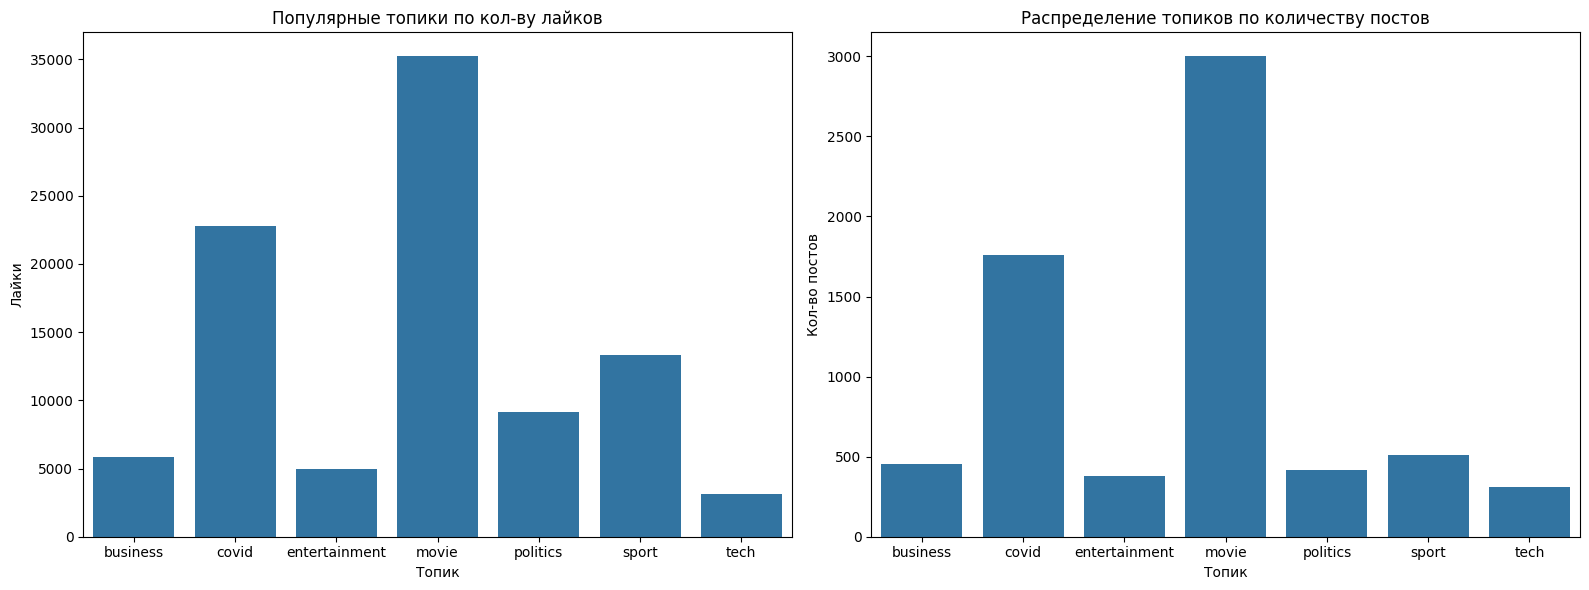

In [448]:
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# # График 1 — лайки
# sns.barplot(
#     data=like_by_topic,
#     x='topic',
#     y='sum_topic',
#     ax=axes[0]
# )
# axes[0].set_title('Популярные топики по кол-ву лайков')
# axes[0].set_xlabel('Топик')
# axes[0].set_ylabel('Лайки')

# # График 2 — количество постов
# sns.barplot(
#     data=like_by_topic,
#     x='topic',
#     y='count_topic',
#     ax=axes[1]
# )
# axes[1].set_title('Распределение топиков по количеству постов')
# axes[1].set_xlabel('Топик')
# axes[1].set_ylabel('Кол-во постов')

# plt.tight_layout()
# plt.show()


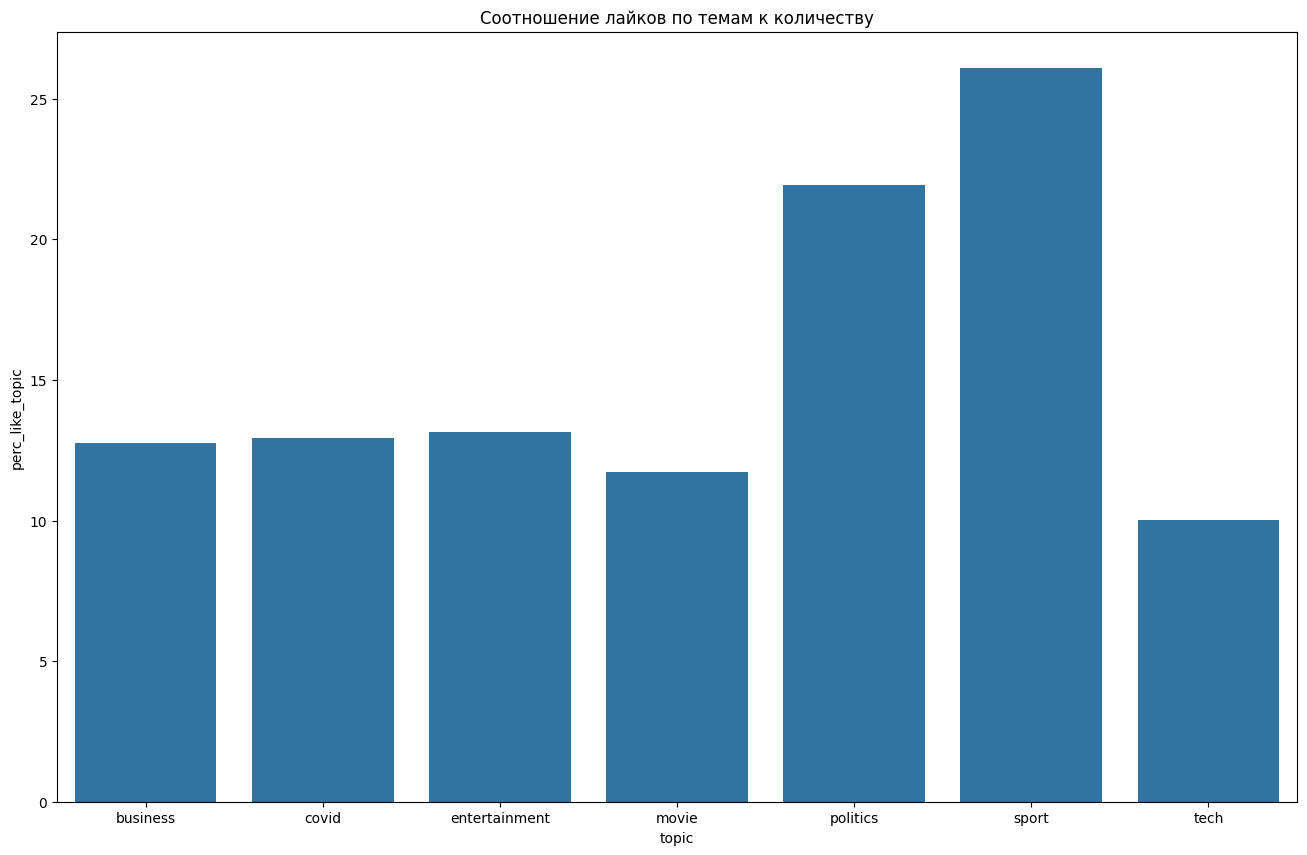

In [449]:
# plt.figure(figsize = (16, 10))
# sns.barplot(data = like_by_topic,
#             x = 'topic',
#             y = 'perc_like_topic')
# plt.title('Соотношение лайков по темам к количеству')
# plt.show()

# Мерджим таблицы

In [34]:
train_full = (train
              .merge(user_features, on="user_id", how="left")
              .merge(post_features, on="post_id", how="left"))

test_full = (test
            .merge(user_features, on="user_id", how="left")
            .merge(post_features, on="post_id", how="left"))

In [35]:
test_full.head()

,timestamp,user_id,post_id,target,day_of_week,hour,age,gender_0,gender_1,os_Android,...,post_like,post_perc_like,topic_perc_like,business,covid,entertainment,movie,politics,sport,tech
0,2021-12-11 20:38:46,19747,5337,0,5,20,19,0,1,1,...,9.0,0.130435,0.116483,0,0,0,1,0,0,0
1,2021-12-11 20:38:46,98558,1407,0,5,20,37,0,1,0,...,35.0,0.147679,0.120415,0,0,0,0,0,1,0
2,2021-12-11 20:38:46,33360,2755,0,5,20,28,0,1,1,...,31.0,0.133621,0.114797,0,1,0,0,0,0,0
3,2021-12-11 20:39:22,25736,2494,0,5,20,74,0,1,0,...,8.0,0.123077,0.114797,0,1,0,0,0,0,0
4,2021-12-11 20:39:32,105544,1076,0,5,20,21,0,1,0,...,23.0,0.104545,0.109425,0,0,0,0,1,0,0


In [36]:
test_full = test_full.drop(['timestamp', 'post_id'], axis = 1)
train_full = train_full.drop(['timestamp', 'post_id'], axis = 1)

In [37]:
X_train = train_full.drop(['target', 'user_id'], axis = 1)
X_test = test_full.drop(['target', 'user_id'], axis = 1)
y_train = train_full['target']
y_test = test_full['target']

In [38]:
X_train.columns.to_list()

['day_of_week',
 'hour',
 'age',
 'gender_0',
 'gender_1',
 'os_Android',
 'os_iOS',
 'source_ads',
 'source_organic',
 'exp_0',
 'exp_1',
 'exp_2',
 'exp_3',
 'exp_4',
 'country_mte',
 'city_mte',
 'likes',
 'perc_like',
 'age_like',
 'age_perc_like',
 'tfidf_mean',
 'tfidf_max',
 'post_like',
 'post_perc_like',
 'topic_perc_like',
 'business',
 'covid',
 'entertainment',
 'movie',
 'politics',
 'sport',
 'tech']

In [39]:
from catboost import CatBoostClassifier
cat_features = ['day_of_week', 'hour']  # все что нельзя напрямую математически сравнить больше чего-то или нет

model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=1,
    verbose=50
)

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    use_best_model=True
)


0:	test: 0.6111536	best: 0.6111536 (0)	total: 700ms	remaining: 3m 29s
50:	test: 0.6659050	best: 0.6661575 (49)	total: 53.6s	remaining: 4m 21s
100:	test: 0.6727062	best: 0.6727062 (100)	total: 1m 46s	remaining: 3m 29s
150:	test: 0.6753156	best: 0.6753156 (150)	total: 2m 32s	remaining: 2m 30s
200:	test: 0.6761984	best: 0.6762029 (199)	total: 3m 22s	remaining: 1m 39s
250:	test: 0.6768992	best: 0.6768992 (250)	total: 4m 15s	remaining: 49.9s
299:	test: 0.6775839	best: 0.6775903 (297)	total: 5m 8s	remaining: 0us

bestTest = 0.6775903168
bestIteration = 297

Shrink model to first 298 iterations.


In [40]:
y_pred = model.predict_proba(X_test)[:, 1]
y_pred

array([0.12889591, 0.01857751, 0.06118863, ..., 0.0462181 , 0.09667244,
       0.02309584])

In [41]:
eval_df = pd.DataFrame({
    "user_id": test_full["user_id"].values,
    "target": y_test.values,
    "pred": y_pred
})

top5 = (eval_df.sort_values(['user_id', 'pred'], ascending=[True, False])
                .groupby('user_id', as_index=False)
                .head(5))

hitrate5 = top5.groupby('user_id')['target'].max().mean()
print("HitRate@5:", round(hitrate5, 4))

HitRate@5: 0.661


In [734]:
"""Сохранение модели"""

model.save_model('catboost_model', format='cbm')